Training set size: 14080
Test set size: 3521
[0]	validation_0-rmse:0.38672
[50]	validation_0-rmse:0.11973
[100]	validation_0-rmse:0.10107
[150]	validation_0-rmse:0.09746
[200]	validation_0-rmse:0.09646
[250]	validation_0-rmse:0.09560
[300]	validation_0-rmse:0.09521
[350]	validation_0-rmse:0.09506
[400]	validation_0-rmse:0.09465
[450]	validation_0-rmse:0.09416
[497]	validation_0-rmse:0.09435
XGBoost MAE: 0.0623
XGBoost RMSE: 0.0941


<Figure size 1000x800 with 0 Axes>

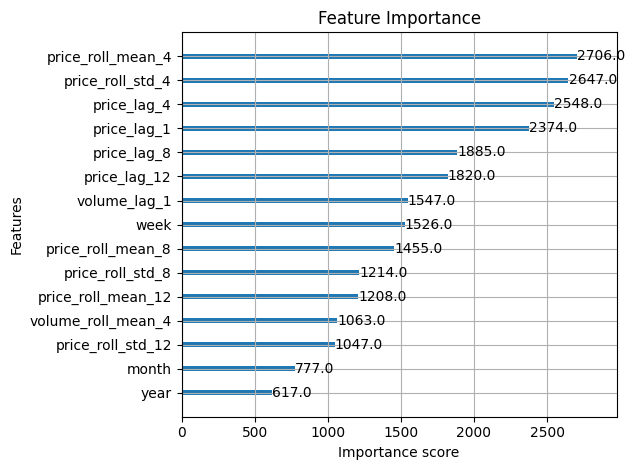

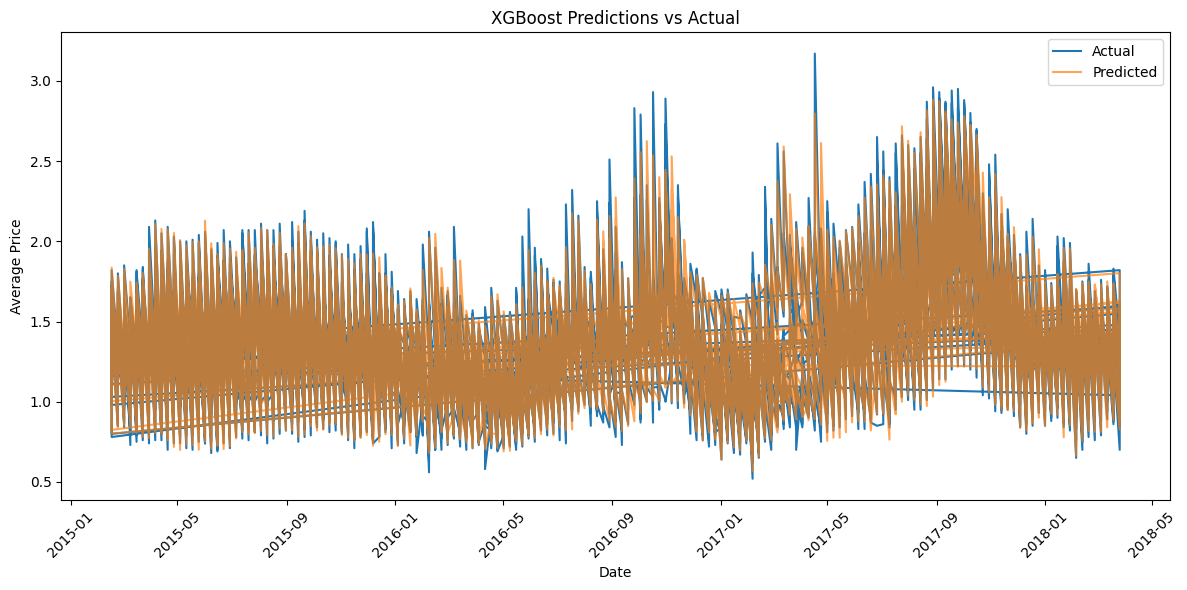

XGBoost model training completed successfully!


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib
import json

# Load features
df = pd.read_csv('../data/avocado_features.csv')
df['date'] = pd.to_datetime(df['date'])

# Define features and target
feature_cols = ['year', 'month', 'week', 'dayofweek', 'is_month_start', 'is_month_end',
                'month_sin', 'month_cos', 'price_lag_1', 'price_lag_4', 'price_lag_8', 'price_lag_12',
                'price_roll_mean_4', 'price_roll_mean_8', 'price_roll_mean_12',
                'price_roll_std_4', 'price_roll_std_8', 'price_roll_std_12',
                'volume_lag_1', 'volume_roll_mean_4', 'region_encoded', 'type_encoded']

X = df[feature_cols]
y = df['AveragePrice']

# Time-based split
dates = df['date']
split_idx = int(len(dates) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_test = dates.iloc[split_idx:]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Create and train model with early_stopping_rounds in constructor
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,  # Moved to constructor
    eval_metric='rmse'  # Add evaluation metric
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGBoost MAE: {mae:.4f}")
print(f"XGBoost RMSE: {rmse:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=15)
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('../models/xgboost_feature_importance.png')
plt.show()

# Save model
joblib.dump(model, '../models/xgboost_model.pkl')

# Save metrics
xgboost_results = {
    'model': 'xgboost',
    'mae': mae,
    'rmse': rmse
}

with open('../models/xgboost_metrics.json', 'w') as f:
    json.dump(xgboost_results, f)

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test.values, label='Actual')
plt.plot(dates_test, y_pred, label='Predicted', alpha=0.7)
plt.title('XGBoost Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../models/xgboost_predictions.png')
plt.show()

print("XGBoost model training completed successfully!")